In [20]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import sklearn.metrics
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression as LR
from sklearn.cross_validation import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier
%matplotlib inline

In [3]:
red_wine_df = pd.read_csv('winequality-red.csv', header = 0, sep=';')

In [3]:
red_wine_df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [7]:
print("Size of 'raw' dataset: {}".format(red_wine_df.shape[0]))
print("Size of dataset without NA values: {}".format(red_wine_df.dropna().shape[0]))

Size of 'raw' dataset: 1599
Size of dataset without NA values: 1599


Как видим датасет полный, без пропусков. Все признаки численные.

In [8]:
print("Minimum value of quality: {}".format(min(red_wine_df['quality'])))
print("Maximum value of quality: {}".format(max(red_wine_df['quality'])))

Minimum value of quality: 3
Maximum value of quality: 8


(array([  10.,   53.,  681.,  638.,  199.,   18.]),
 array([ 2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5]),
 <a list of 6 Patch objects>)

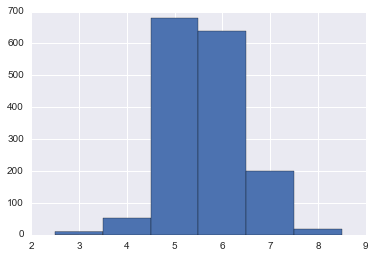

In [9]:
plt.hist(red_wine_df['quality'], bins=6, range = (2.5, 8.5))

Как видим, классы сильно несбалансированы, это должно учитываться при обучении модели, возможно нам придется применить методы балансировки классов.

Сперва разделим выборку на обучающую и тестовую(в соотношении 7 к 3), и посмотрим насколько хорошо с задачей регресии для данного датасета справляется простейшая линейная регрессия.

In [10]:
red_wine_df_features = red_wine_df.drop(['quality'], axis = 1)
red_wine_df_labels = red_wine_df['quality']
train_data, test_data, train_labels, test_labels = train_test_split(red_wine_df_features, 
                                                                                     red_wine_df_labels, 
                                                                                     test_size = 0.3,
                                                                    stratify=red_wine_df_labels,
                                                                   random_state=42)
regressor = LR(n_jobs = 4)
regressor.fit(train_data, train_labels)
r2 = regressor.score(test_data, test_labels)
mse =  mean_squared_error(regressor.predict(test_data), test_labels)
print("MSE for the linear regression is {:1.3f}".format(mse))
print("R2 for the linear regression is {:1.3f}".format(r2))

MSE for the linear regression is 0.408
R2 for the linear regression is 0.371


Результат ужасен(r2 ниже 0.5). Попробуем отмасштибировать признаки и провести регресиию заново.

In [11]:
red_wine_df_features = StandardScaler().fit_transform(red_wine_df.drop(['quality'], axis = 1))
red_wine_df_labels = red_wine_df['quality']
train_data, test_data, train_labels, test_labels = train_test_split(red_wine_df_features, 
                                                                                     red_wine_df_labels, 
                                                                                     test_size = 0.3,
                                                                    stratify=red_wine_df_labels,
                                                                   random_state=42)
regressor = LR(n_jobs = 4)
regressor.fit(train_data, train_labels)
r2 = regressor.score(test_data, test_labels)
mse =  mean_squared_error(regressor.predict(test_data), test_labels)
print("MSE for the linear regression is {:1.3f}".format(mse))
print("R2 for the linear regression is {:1.3f}".format(r2))

MSE for the linear regression is 0.408
R2 for the linear regression is 0.371


Не видим никакого улучшения. Попробуем отсеять неинформативные признаки. Для этого построим сперва графики, на которых будут отображены значения признаков для вин разного качества, а далее посмотрим на корреляцию целевого признака с остальными признаками.

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()


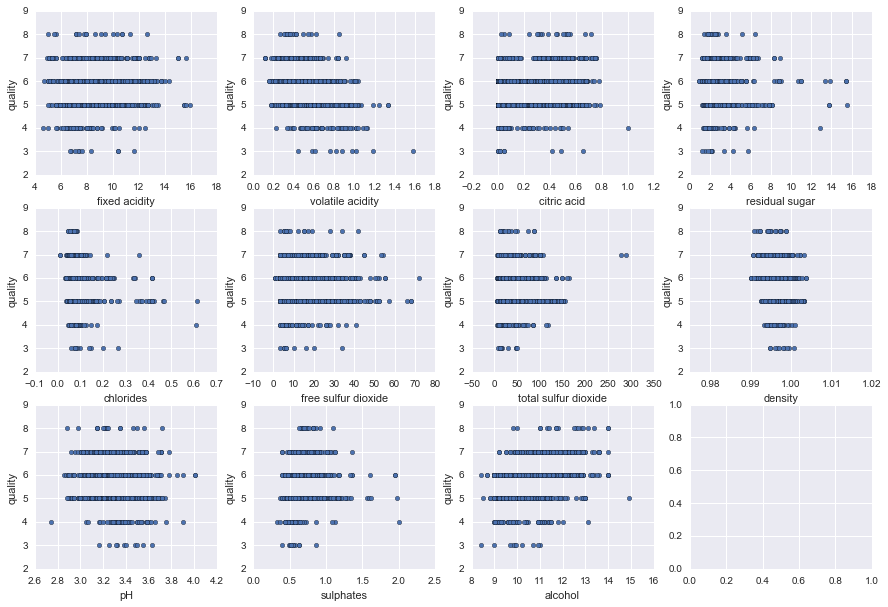

In [12]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15, 10))
for idx, feature in enumerate(red_wine_df.columns[:-1]):
    red_wine_df.plot(feature, "quality", subplots=True, kind="scatter", ax=axes[idx / 4, idx % 4])

#### Корреляция целевого признака с остальными

In [13]:
red_wine_df.ix[:,0:red_wine_df.shape[-1]-1].corrwith(red_wine_df.quality)

fixed acidity           0.124052
volatile acidity       -0.390558
citric acid             0.226373
residual sugar          0.013732
chlorides              -0.128907
free sulfur dioxide    -0.050656
total sulfur dioxide   -0.185100
density                -0.174919
pH                     -0.057731
sulphates               0.251397
alcohol                 0.476166
dtype: float64

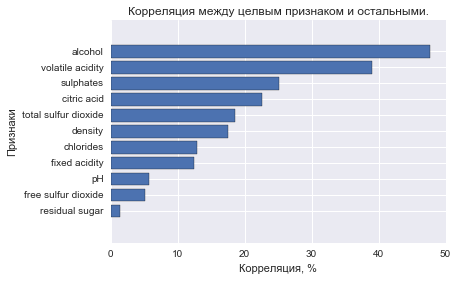

In [14]:
import operator
plt.figure(1)
pos = list(range(0,len(red_wine_df.columns) - 1))
val = abs(red_wine_df.ix[:,0:red_wine_df.shape[-1]-1].corrwith(red_wine_df.quality))
zip_list = sorted(list(zip(red_wine_df.drop(['quality'], axis=1).columns, val)), key = operator.itemgetter(1))
ys = [x[1] * 100. for x in zip_list]
xs = [x[0] for x in zip_list]
plt.barh(pos, ys, align='center')
plt.yticks(pos, xs)
plt.xlabel('Корреляция, %')
plt.ylabel('Признаки')
plt.title('Корреляция между целвым признаком и остальными.')
plt.grid(True)

#### Корреляция нецелвых признаков друг с другом

In [15]:
red_wine_df.drop(['quality'], axis = 1).corr()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
fixed acidity,1.000000,-0.256131,0.671703,0.114777,0.093705,-0.153794,-0.113181,0.668047,-0.682978,0.183006,-0.061668
volatile acidity,-0.256131,1.000000,-0.552496,0.001918,0.061298,-0.010504,0.076470,0.022026,0.234937,-0.260987,-0.202288
citric acid,0.671703,-0.552496,1.000000,0.143577,0.203823,-0.060978,0.035533,0.364947,-0.541904,0.312770,0.109903
residual sugar,0.114777,0.001918,0.143577,1.000000,0.055610,0.187049,0.203028,0.355283,-0.085652,0.005527,0.042075
chlorides,0.093705,0.061298,0.203823,0.055610,1.000000,0.005562,0.047400,0.200632,-0.265026,0.371260,-0.221141
free sulfur dioxide,-0.153794,-0.010504,-0.060978,0.187049,0.005562,1.000000,0.667666,-0.021946,0.070377,0.051658,-0.069408
total sulfur dioxide,-0.113181,0.076470,0.035533,0.203028,0.047400,0.667666,1.000000,0.071269,-0.066495,0.042947,-0.205654
density,0.668047,0.022026,0.364947,0.355283,0.200632,-0.021946,0.071269,1.000000,-0.341699,0.148506,-0.496180
pH,-0.682978,0.234937,-0.541904,-0.085652,-0.265026,0.070377,-0.066495,-0.341699,1.000000,-0.196648,0.205633
sulphates,0.183006,-0.260987,0.312770,0.005527,0.371260,0.051658,0.042947,0.148506,-0.196648,1.000000,0.093595


Видим, что признаки 'resudual sugar', 'pH' и 'free sulfur dioxide' имеют сравнительно низкую корреляцию с целевым признаком. Исключим их из выборки и попробуем заново построить модель.
Также видим, что некоторые нецелвые признаки имеют выскокую корреляцию между собой, это наводит на мысль о введении регуляризации в нашу модель.

In [16]:
red_wine_df_features = StandardScaler().fit_transform(red_wine_df.drop(['pH','residual sugar', 'free sulfur dioxide','quality'], axis = 1))
red_wine_df_labels = red_wine_df['quality']
train_data, test_data, train_labels, test_labels = train_test_split(red_wine_df_features, 
                                                                                     red_wine_df_labels, 
                                                                                     test_size = 0.3,
                                                                    stratify=red_wine_df_labels,
                                                                   random_state=42)
regressor = LR(n_jobs = 4)
regressor.fit(train_data, train_labels)
r2 = regressor.score(test_data, test_labels)
mse =  mean_squared_error(regressor.predict(test_data), test_labels)
print("MSE for the linear regression is {:1.3f}".format(mse))
print("R2 for the linear regression is {:1.3f}".format(r2))

MSE for the linear regression is 0.403
R2 for the linear regression is 0.378


Добавим Lasso регуляризацию.

In [17]:
from sklearn.linear_model import LassoCV
red_wine_df_features = StandardScaler().fit_transform(red_wine_df.drop(['quality'], axis = 1))
red_wine_df_labels = red_wine_df['quality']
train_data, test_data, train_labels, test_labels = train_test_split(red_wine_df_features, 
                                                                                     red_wine_df_labels, 
                                                                                     test_size = 0.3,
                                                                    stratify=red_wine_df_labels,
                                                                   random_state=42)
regressor = LassoCV(alphas = [0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 1.])
regressor.fit(train_data, train_labels)
r2 = regressor.score(test_data, test_labels)
mse =  mean_squared_error(regressor.predict(test_data), test_labels)
print("MSE for the linear regression is {:1.3f}".format(mse))
print("R2 for the linear regression is {:1.3f}".format(r2))

MSE for the linear regression is 0.405
R2 for the linear regression is 0.375


Видим, что качество модели всё ещё невысоко. Попробуем вместо задачи регресии решать задачу многоклассовой 
классификации(где классами будут выступать значения аттрибута 'quality' от 3 до 8). 
Попробем использовать различные классификаторы. Также попробуем сбалансировать классы и посмотреть как это повлияет на точность и какой получится confusion matrix.

In [22]:
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
import warnings
warnings.filterwarnings('ignore')

def measure_classifier(classifier, classifier_name, data, target, target_names):
    score = cross_val_score(classifier, data, target, cv = 5, ).mean()
    train_data, test_data, train_labels, test_labels = train_test_split(data, target, test_size = 0.3,
                                                                    stratify=target, random_state=42)
    classifier.fit(train_data, train_labels)
    pred_labels = classifier.predict(test_data)    
    print("Classification report for the {}".format(classifier_name))
    print(classification_report(test_labels, pred_labels, labels = target_names, target_names=target_names))
    cv_score = cross_val_score(classifier, data, target, scoring='f1_weighted', cv = 10).mean()
    print("Cross validated weihted f1 score for the {} is {:1.3f}".format(classifier_name, cv_score)) 
    return cv_score

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

red_wine_df_features = StandardScaler().fit_transform(red_wine_df.drop(['quality'], axis = 1))
red_wine_df_labels = red_wine_df['quality']
def check_different_classifiers_at_data(data, target, target_names):
    measure_classifier(LogisticRegression(solver='newton-cg'), "one-versus-rest logisticregression", data, target, target_names)
    measure_classifier(LogisticRegression(multi_class='multinomial', solver='newton-cg'), "multinominal logisticregression", data, target, target_names)
    measure_classifier(LogisticRegression(class_weight='balanced'), "balanced logisticregression", data, target, target_names)
    measure_classifier(DecisionTreeClassifier(), "Decision Tree Classifier", data, target,target_names)
    measure_classifier(RandomForestClassifier(), "Random Forest Classifier", data, target,target_names)

check_different_classifiers_at_data(red_wine_df_features, red_wine_df_labels,['3','4','5','6','7','8'])

Classification report for the one-versus-rest logisticregression
             precision    recall  f1-score   support

          3       0.00      0.00      0.00         3
          4       0.00      0.00      0.00        16
          5       0.65      0.78      0.71       204
          6       0.53      0.62      0.57       192
          7       0.57      0.07      0.12        60
          8       0.00      0.00      0.00         5

avg / total       0.56      0.59      0.54       480

Cross validated weihted f1 score for the one-versus-rest logisticregression is 0.542
Classification report for the multinominal logisticregression
             precision    recall  f1-score   support

          3       0.00      0.00      0.00         3
          4       0.00      0.00      0.00        16
          5       0.66      0.75      0.70       204
          6       0.55      0.64      0.59       192
          7       0.67      0.23      0.35        60
          8       0.00      0.00      0.00

In [24]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "%2.1f" % (cm[i, j] * 100) + "%",
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.grid(False)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(title+".png", bbox_inches='tight')

In [25]:
from sklearn.metrics import confusion_matrix
def buildConfusionMatrixFor(classifier, data, target, title, classes=list(range(3,9)), normalize=True, cmap=plt.cm.Blues):
    train_data, test_data, train_labels, test_labels = train_test_split(data, target, test_size = 0.3,
                                                                    stratify=target, random_state=42)
    classifier.fit(train_data, train_labels)
    cnf_matrix = confusion_matrix(test_labels, classifier.predict(test_data), labels=classes)
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=classes, title=title, normalize=normalize, cmap=cmap)

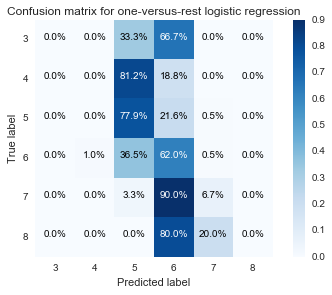

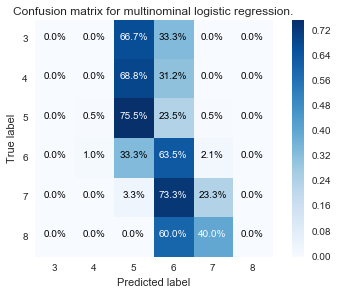

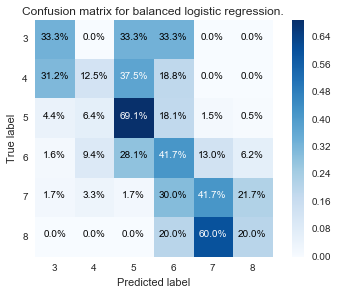

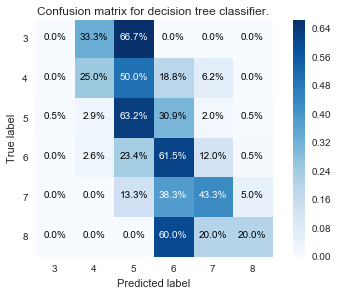

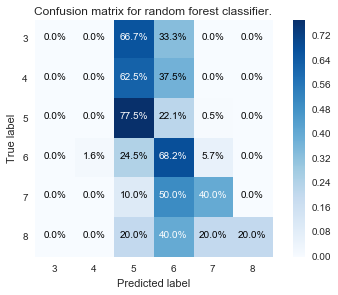

In [26]:
buildConfusionMatrixFor(LogisticRegression(solver='newton-cg'), red_wine_df_features, red_wine_df_labels, title='Confusion matrix for one-versus-rest logistic regression')
buildConfusionMatrixFor(LogisticRegression(multi_class='multinomial', solver='newton-cg'), red_wine_df_features, red_wine_df_labels, title='Confusion matrix for multinominal logistic regression.')
buildConfusionMatrixFor(LogisticRegression(class_weight='balanced'), red_wine_df_features, red_wine_df_labels, title='Confusion matrix for balanced logistic regression.')
buildConfusionMatrixFor(DecisionTreeClassifier(), red_wine_df_features, red_wine_df_labels, title='Confusion matrix for decision tree classifier.')
buildConfusionMatrixFor(RandomForestClassifier(), red_wine_df_features, red_wine_df_labels, title='Confusion matrix for random forest classifier.')

Кажется, мы уперлись в потолок с текущими данными. Попробуем упростить себе задачу и изменить классы: классы 3 и 4 объединим в класс bad, 5 в класс OK, 6 в класс fine, 7 и 8 в класс good и повторить тесты.

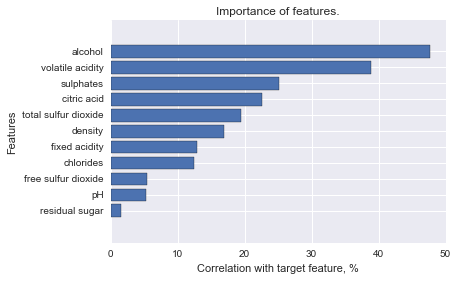

In [533]:
import operator
plt.figure(1)
pos = list(range(0,len(red_wine_df.columns) - 1))
val = abs(red_wine_changed.ix[:,0:red_wine_changed.shape[-1]-1].corrwith(red_wine_changed.quality))
zip_list = sorted(list(zip(red_wine_df.drop(['quality'], axis=1).columns, val)), key = operator.itemgetter(1))
ys = [x[1] * 100. for x in zip_list]
xs = [x[0] for x in zip_list]
fig, ax = plt.subplots()
rec = plt.barh(pos, ys, align='center')
plt.yticks(pos, xs)
plt.xlabel('Correlation with target feature, %')
plt.ylabel('Features')
plt.title('Importance of features.')
plt.grid(True)
plt.savefig('importance.png', bbox_inches='tight')

In [248]:
red_wine_df_features = StandardScaler().fit_transform(red_wine_df.drop(['quality'], axis = 1))
red_wine_df_labels = red_wine_df['quality']
class_mapping = {3: 'bad', 4: 'bad', 5: 'ok', 6: 'fine', 7: 'good', 8: 'good'}
new_labels = red_wine_df_labels.map(lambda x: class_mapping[x])
check_different_classifiers_at_data(red_wine_df_features, new_labels, ['bad', 'ok', 'fine', 'good'])

Classification report for the one-versus-rest logisticregression
             precision    recall  f1-score   support

        bad       0.00      0.00      0.00        19
         ok       0.64      0.78      0.70       204
       fine       0.58      0.59      0.59       192
       good       0.62      0.32      0.42        65

avg / total       0.59      0.61      0.59       480

Cross validated f1 score for the one-versus-rest logisticregression is 0.561
Classification report for the multinominal logisticregression
             precision    recall  f1-score   support

        bad       0.00      0.00      0.00        19
         ok       0.65      0.76      0.70       204
       fine       0.59      0.60      0.60       192
       good       0.59      0.40      0.48        65

avg / total       0.59      0.62      0.60       480

Cross validated f1 score for the multinominal logisticregression is 0.574
Classification report for the balanced logisticregression
             precision

Видим некоторое улучшение метрик для всех методов. Видим, что Random Forest показывает хорошие показатели метрик при простой разбивки на тестовую и обучающую выборку и плохие показатели метрик при кросс-валидации. ОЧевидно, что мы имеем дело с его переобучением. Но поскольку его показтели при простом мплите лучше остальных методов, дальнейшую работу будем вести именно с ним. 

In [30]:
def measure_classifier_test_train(classifier, classifier_name, data, target, target_names):
    score = cross_val_score(classifier, data, target, cv = 5, ).mean()
    train_data, test_data, train_labels, test_labels = train_test_split(data, target, test_size = 0.3,
                                                                    stratify=target, random_state=42)
    classifier.fit(train_data, train_labels)  
    print("Classification report(train) for the {}".format(classifier_name))
    print(classification_report(train_labels, classifier.predict(train_data) , labels = target_names, target_names=target_names))
    print("Classification report(test) for the {}".format(classifier_name))
    print(classification_report(test_labels, classifier.predict(test_data), labels = target_names, target_names=target_names))
    cv_score = cross_val_score(classifier, data, target, scoring='f1_weighted', cv = 10).mean()
    print("Cross validated weighted f1 score for the {} is {:1.3f}".format(classifier_name, cv_score)) 
    cnf_matrix = confusion_matrix(test_labels, classifier.predict(test_data), labels=target_names)
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=target_names, title='Confusion matrix for '+classifier_name, normalize=True, cmap=plt.cm.Blues)
    return cv_score

Classification report(train) for the random forest classifier
             precision    recall  f1-score   support

        bad       1.00      0.95      0.98        44
         ok       0.99      0.99      0.99       477
       fine       0.97      0.99      0.98       446
       good       1.00      0.95      0.98       152

avg / total       0.98      0.98      0.98      1119

Classification report(test) for the random forest classifier
             precision    recall  f1-score   support

        bad       0.00      0.00      0.00        19
         ok       0.74      0.70      0.72       204
       fine       0.61      0.78      0.69       192
       good       0.72      0.45      0.55        65

avg / total       0.66      0.67      0.65       480

Cross validated weighted f1 score for the random forest classifier is 0.524


0.52368358218732358

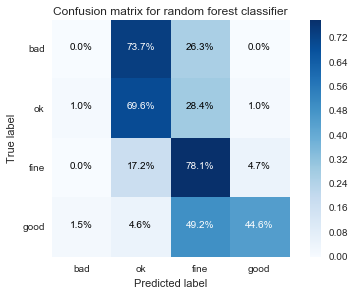

In [31]:
red_wine_df_features = StandardScaler().fit_transform(red_wine_df.drop(['quality'], axis = 1))
red_wine_df_labels = red_wine_df['quality']
class_mapping = {3: 'bad', 4: 'bad', 5: 'ok', 6: 'fine', 7: 'good', 8: 'good'}
new_labels = red_wine_df_labels.map(lambda x: class_mapping[x])
measure_classifier_test_train(RandomForestClassifier(), 'random forest classifier', red_wine_df_features, new_labels, ['bad', 'ok', 'fine', 'good'])

Classification report(train) for the random forest classifier
             precision    recall  f1-score   support

        bad       1.00      1.00      1.00        44
         ok       0.99      0.99      0.99       477
       fine       0.98      0.99      0.98       446
       good       0.99      0.97      0.98       152

avg / total       0.99      0.99      0.99      1119

Classification report(test) for the random forest classifier
             precision    recall  f1-score   support

        bad       0.33      0.05      0.09        19
         ok       0.72      0.73      0.73       204
       fine       0.61      0.72      0.66       192
       good       0.62      0.40      0.49        65

avg / total       0.65      0.65      0.64       480

Cross validated weighted f1 score for the random forest classifier is 0.518


0.51830965230102066

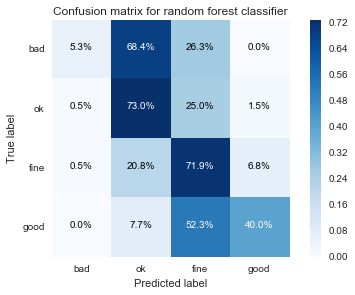

In [32]:
from sklearn.preprocessing import PolynomialFeatures
transform = PolynomialFeatures(2)
red_wine_df_features_poly = transform.fit_transform(red_wine_df_features)
measure_classifier_test_train(RandomForestClassifier(), 'random forest classifier', red_wine_df_features_poly, new_labels, ['bad', 'ok', 'fine', 'good'])

Как видим добавление квадратичных признаков не имеет существенного влияния на качество модели.
Попробуем найти наилучшие параметры для нашего случайного леса перебором по сетке.

Classification report(train) for the random forest classifier
             precision    recall  f1-score   support

        bad       1.00      1.00      1.00        44
         ok       1.00      1.00      1.00       477
       fine       1.00      1.00      1.00       446
       good       1.00      1.00      1.00       152

avg / total       1.00      1.00      1.00      1119

Classification report(test) for the random forest classifier
             precision    recall  f1-score   support

        bad       0.00      0.00      0.00        19
         ok       0.75      0.80      0.78       204
       fine       0.68      0.78      0.72       192
       good       0.71      0.46      0.56        65

avg / total       0.69      0.71      0.70       480

Cross validated weighted f1 score for the random forest classifier is 0.558


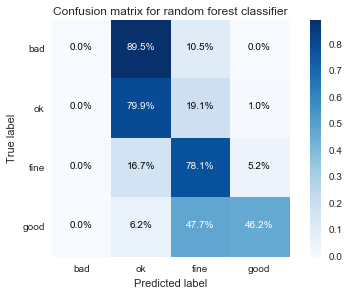

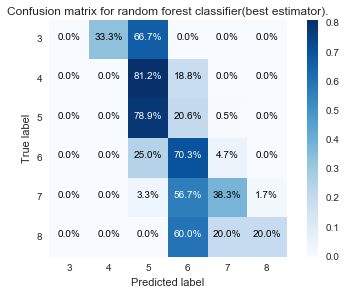

In [33]:
import sklearn.cross_validation
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.grid_search import GridSearchCV
parameters_grid = {
    'max_features' : ['sqrt','log2'],
    'n_estimators' : [50, 100, 200],
    'max_depth' : [5, 10, 15, 20],
    'min_samples_split' : [2,3,5,10],
    'min_samples_leaf' : [1,2,5,10]
}
cv = StratifiedShuffleSplit(red_wine_df_labels, n_iter = 3, test_size = 0.3, random_state = 0)
grid_cv = GridSearchCV(RandomForestClassifier(), parameters_grid, scoring = 'f1_weighted', cv = cv)
grid_cv.fit(red_wine_df_features, red_wine_df_labels)
best_estimator = grid_cv.best_estimator_
measure_classifier_test_train(best_estimator, 'random forest classifier', red_wine_df_features, new_labels, ['bad', 'ok', 'fine', 'good'])
buildConfusionMatrixFor(best_estimator, red_wine_df_features, red_wine_df_labels, title='Confusion matrix for random forest classifier(best estimator).')

Classification report(train) for the random forest classifier
             precision    recall  f1-score   support

        bad       1.00      1.00      1.00        44
         ok       1.00      1.00      1.00       477
       fine       1.00      1.00      1.00       446
       good       1.00      1.00      1.00       152

avg / total       1.00      1.00      1.00      1119

Classification report(test) for the random forest classifier
             precision    recall  f1-score   support

        bad       0.00      0.00      0.00        19
         ok       0.74      0.80      0.77       204
       fine       0.69      0.74      0.72       192
       good       0.69      0.54      0.60        65

avg / total       0.68      0.71      0.70       480

Cross validated weighted f1 score for the random forest classifier is 0.551


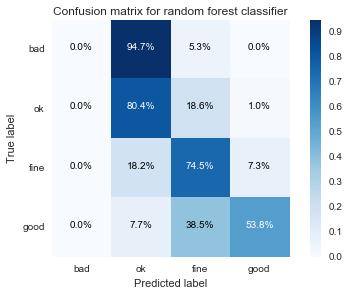

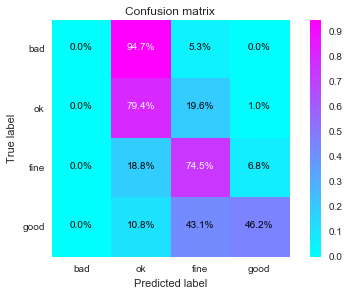

In [34]:
measure_classifier_test_train(best_estimator, 'random forest classifier', red_wine_df_features, new_labels, ['bad', 'ok', 'fine', 'good'])

In [35]:
print(grid_cv.best_params_)
print(grid_cv.best_score_)

{'max_features': 'log2', 'n_estimators': 100, 'max_depth': 20}
0.678903811028


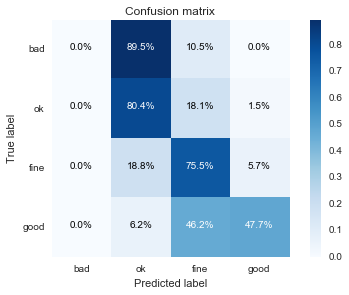

In [36]:
buildConfusionMatrixFor(best_estimator, red_wine_df_features, new_labels, title='Confusion matrix',classes = ['bad', 'ok', 'fine', 'good'], cmap=plt.cm.Blues)

Classification report(train) for the random forest classifier
             precision    recall  f1-score   support

        bad       1.00      1.00      1.00        44
         ok       1.00      1.00      1.00       477
       fine       1.00      1.00      1.00       446
       good       1.00      1.00      1.00       152

avg / total       1.00      1.00      1.00      1119

Classification report(test) for the random forest classifier
             precision    recall  f1-score   support

        bad       0.00      0.00      0.00        19
         ok       0.76      0.79      0.77       204
       fine       0.69      0.79      0.74       192
       good       0.74      0.52      0.61        65

avg / total       0.70      0.72      0.71       480

Cross validated weighted f1 score for the random forest classifier is 0.561


0.56120440478153411

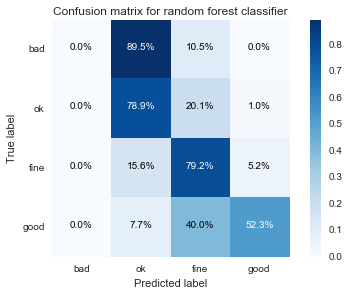

In [37]:
measure_classifier_test_train(best_estimator, 'random forest classifier', red_wine_df_features, new_labels, ['bad', 'ok', 'fine', 'good'])

In [38]:
def show_values(pc, fmt="%.2f", **kw):
    '''
    Heatmap with text in each cell with matplotlib's pyplot
    Source: http://stackoverflow.com/a/25074150/395857 
    By HYRY
    '''
    pc.update_scalarmappable()
    ax = pc.get_axes()
    for p, color, value in zip(pc.get_paths(), pc.get_facecolors(), pc.get_array()):
        x, y = p.vertices[:-1, :].mean(0)
        if np.all(color[:3] > 0.5):
            color = (0.0, 0.0, 0.0)
        else:
            color = (1.0, 1.0, 1.0)
        ax.text(x, y, fmt % value, ha="center", va="center", color=color, **kw)


def cm2inch(*tupl):
    '''
    Specify figure size in centimeter in matplotlib
    Source: http://stackoverflow.com/a/22787457/395857
    By gns-ank
    '''
    inch = 2.54
    if type(tupl[0]) == tuple:
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)


def heatmap(AUC, title, xlabel, ylabel, xticklabels, yticklabels, figure_width=40, figure_height=20, correct_orientation=False, cmap='RdBu'):
    '''
    Inspired by:
    - http://stackoverflow.com/a/16124677/395857 
    - http://stackoverflow.com/a/25074150/395857
    '''

    # Plot it out
    fig, ax = plt.subplots()    
    #c = ax.pcolor(AUC, edgecolors='k', linestyle= 'dashed', linewidths=0.2, cmap='RdBu', vmin=0.0, vmax=1.0)
    c = ax.pcolor(AUC, edgecolors='k', linestyle= 'dashed', linewidths=0.2, cmap=cmap)

    # put the major ticks at the middle of each cell
    ax.set_yticks(np.arange(AUC.shape[0]) + 0.5, minor=False)
    ax.set_xticks(np.arange(AUC.shape[1]) + 0.5, minor=False)

    # set tick labels
    #ax.set_xticklabels(np.arange(1,AUC.shape[1]+1), minor=False)
    ax.set_xticklabels(xticklabels, minor=False)
    ax.set_yticklabels(yticklabels, minor=False)

    # set title and x/y labels
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)      

    # Remove last blank column
    plt.xlim( (0, AUC.shape[1]) )

    # Turn off all the ticks
    ax = plt.gca()    
    for t in ax.xaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False
    for t in ax.yaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False

    # Add color bar
    plt.colorbar(c)

    # Add text in each cell 
    show_values(c)

    # Proper orientation (origin at the top left instead of bottom left)
    if correct_orientation:
        ax.invert_yaxis()
        ax.xaxis.tick_top()       

    # resize 
    fig = plt.gcf()
    #fig.set_size_inches(cm2inch(40, 20))
    #fig.set_size_inches(cm2inch(40*4, 20*4))
    fig.set_size_inches(cm2inch(figure_width, figure_height))



def plot_classification_report(classification_report, title='Classification report ', cmap='RdBu'):
    '''
    Plot scikit-learn classification report.
    Extension based on http://stackoverflow.com/a/31689645/395857 
    '''
    lines = classification_report.split('\n')

    classes = []
    plotMat = []
    support = []
    class_names = []
    for line in lines[2 : (len(lines) - 1)]:
        t = line.strip().split()
        if len(t) < 2: continue
        classes.append(t[0])
        v = [float(x) for x in t[1: len(t) - 1]]
        support.append(int(t[-1]))
        class_names.append(t[0])
        print(v)
        plotMat.append(v)

    print('plotMat: {0}'.format(plotMat))
    print('support: {0}'.format(support))

    xlabel = 'Metrics'
    ylabel = 'Classes'
    xticklabels = ['Precision', 'Recall', 'F1-score']
    yticklabels = ['{0} ({1})'.format(class_names[idx], sup) for idx, sup  in enumerate(support)]
    figure_width = 25
    figure_height = len(class_names) + 7
    correct_orientation = False
    heatmap(np.array(plotMat), title, xlabel, ylabel, xticklabels, yticklabels, figure_width, figure_height, correct_orientation, cmap=cmap)


sampleClassificationReport = """             precision    recall  f1-score   support

          
        bad       0.00      0.00      0.00        19
         ok       0.75      0.79      0.77       204
       fine       0.67      0.78      0.72       192
       good       0.67      0.43      0.52        65

"""


plot_classification_report(sampleClassificationReport)
plt.savefig('test_plot_classif_report.png', dpi=200, format='png', bbox_inches='tight')
plt.close()

[0.0, 0.0, 0.0]
[0.75, 0.79, 0.77]
[0.67, 0.78, 0.72]
[0.67, 0.43, 0.52]
plotMat: [[0.0, 0.0, 0.0], [0.75, 0.79, 0.77], [0.67, 0.78, 0.72], [0.67, 0.43, 0.52]]
support: [19, 204, 192, 65]


In [6]:
from sklearn.metrics import precision_recall_fscore_support
arr = [[0.0, 0.0, 0.0], [0.75, 0.79, 0.77], [0.67, 0.78, 0.72], [0.67, 0.43, 0.52]]
fig, ax = plt.subplots()
rects1 = ax.bar(ind, men_means, width, color='r', yerr=men_std)

women_means = (25, 32, 34, 20, 25)
women_std = (3, 5, 2, 3, 3)
rects2 = ax.bar(ind + width, women_means, width, color='y', yerr=women_std)

In [42]:
import plotly.plotly as py
import plotly.graph_objs as go
py.signin('Bakly23', '')

trace1 = go.Bar(
    x=['giraffes', 'orangutans', 'monkeys'],
    y=[20, 14, 23],
    name='SF Zoo'
)
trace2 = go.Bar(
    x=['giraffes', 'orangutans', 'monkeys'],
    y=[12, 18, 29],
    name='LA Zoo'
)

data = [trace1, trace2]
layout = go.Layout(
    barmode='group'
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='grouped-bar')

PlotlyLocalCredentialsError: 
Couldn't find a 'username', 'api-key' pair for you on your local machine. To sign in temporarily (until you stop running Python), run:
>>> import plotly.plotly as py
>>> py.sign_in('username', 'api_key')

Even better, save your credentials permanently using the 'tools' module:
>>> import plotly.tools as tls
>>> tls.set_credentials_file(username='username', api_key='api-key')

For more help, see https://plot.ly/python.


SyntaxError: invalid syntax (<ipython-input-41-d6d3d4898bad>, line 1)